# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


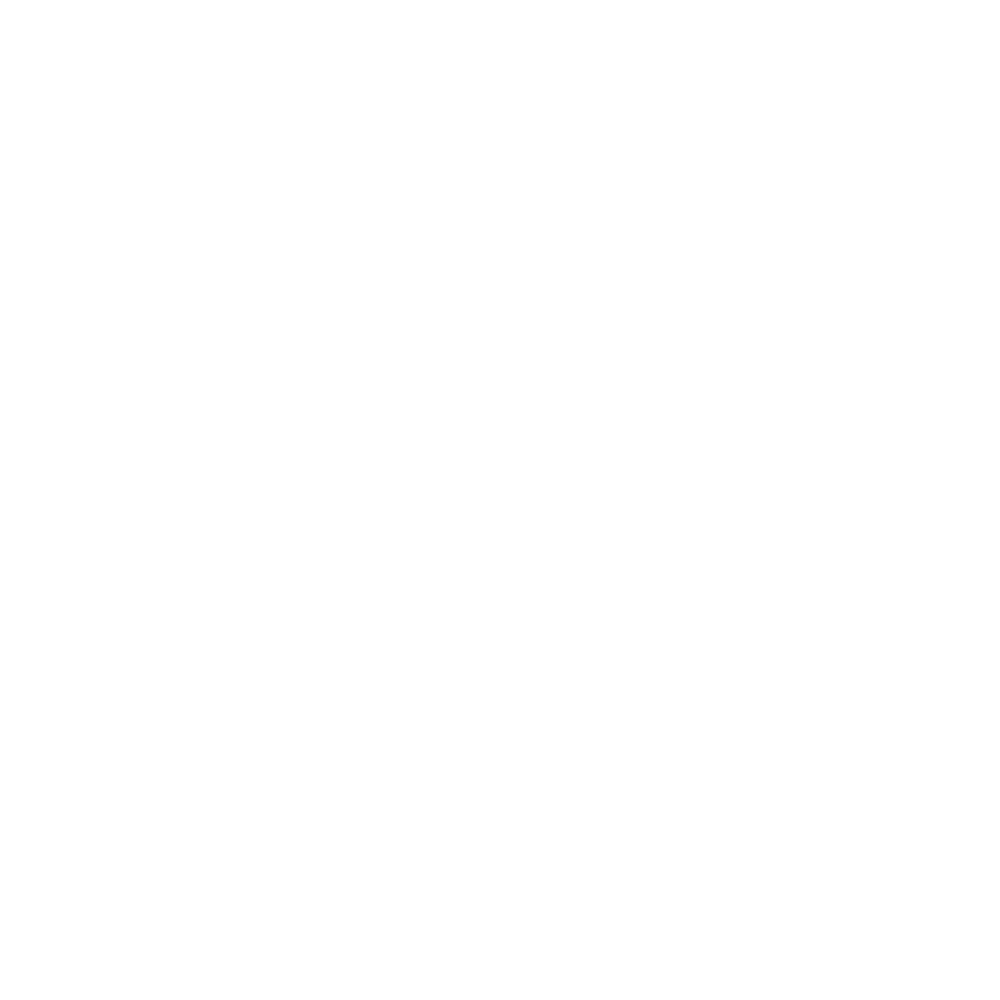

In [84]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

## First, import relevant Python libraries, initialize magic commands, and read the main dataset

In [85]:
%matplotlib notebook
import datetime as dt
import numpy as np

In [86]:
# Read the main (the only) dataset
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

### 3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.

In [87]:
# Revised dataset: (1) Feb 29th removed from all years
# (2) 'Date' values changed from str objects to pd.Timestamp objects (so that the domain of these objects can be assigned
# to x-axis in plt.plot)
# (3) with hierarchical index in terms of 'Element' and 'Date'
df_copy = df

In [88]:
# (3) Initially set index to be 'Date' column
df_copy = df.set_index(['Date'])

In [89]:
# (1) Take slice of dataframe by index labels which do not contain string '-02-29'
df_copy = df_copy.loc[~df_copy.index.str.contains('-02-29')]

In [90]:
# (2) Change object type of index labels from string to pd.datetime objects (or timestamps)
df_copy.index = pd.to_datetime(df_copy.index)

In [91]:
# (3) add 'Element' to index to create a multiindex
df_copy.set_index('Element',append=True, inplace = True)
df_copy = df_copy.swaplevel(i = 'Date', j = 'Element', axis = 0)

In [92]:
# (3) Sort index labels from level = 0 in ascending order
df_copy.sort_index(level = 0, ascending = True, inplace = True)

In [93]:
# check the length of df_copy. It should be 165002 instead of 165085
#len(df_copy)

### 1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.

<IPython.core.display.Javascript object>


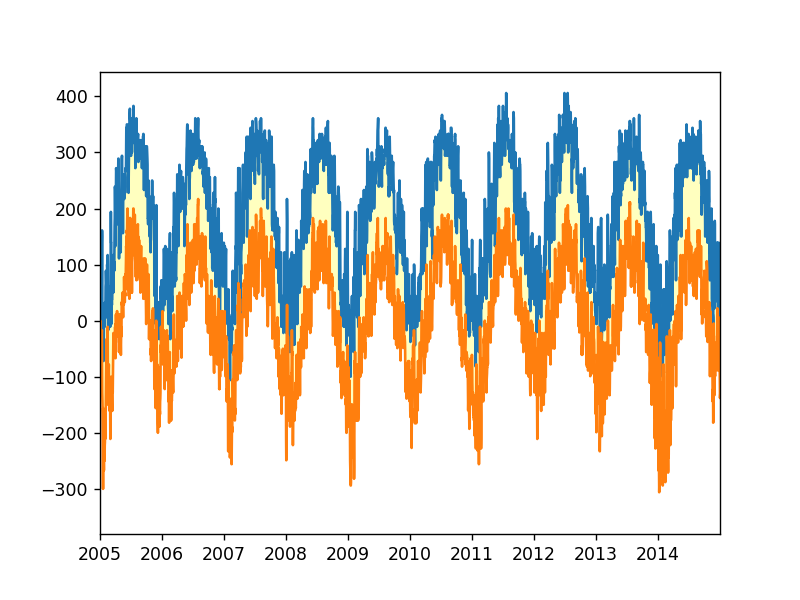

In [94]:
#create figure with two line graphs, one for 'TMAX' and one for 'TMIN' of index level = 0 of df_copy
for tmax_tmin in df_copy.index.get_level_values(0).unique():
    if tmax_tmin == 'TMAX':
        y_values_tmax = list(map(lambda z: df_copy.loc[tmax_tmin, z].max()[1], df_copy.loc[tmax_tmin].index.unique()))
        plt.plot(df_copy.loc[tmax_tmin].index.unique(), y_values_tmax, '-')
    else:
        y_values_tmin = list(map(lambda z: df_copy.loc[tmax_tmin, z].min()[1], df_copy.loc[tmax_tmin].index.unique()))
        plt.plot(df_copy.loc[tmax_tmin].index.unique(), y_values_tmin, '-')

# Set start and end range of the graph to be 2005-01-01 and 2014-12-31 respectively
ax = plt.gca()
ax.set_xlim(left = dt.date(2005, 1, 1), right = dt.date(2014, 12, 31))
# shade the space between TMAX and TMIN of each day
ax.fill_between(df_copy.loc[tmax_tmin].index.unique(), 
                       y_values_tmax, y_values_tmin, 
                       facecolor='yellow', 
                       alpha=0.25)

### 2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015

In [95]:
# First take df_copy and use boolean masking on the column 'Data_Value' (i.e. view the values of this column as either
# True or False) for all rows satisfying the following two conditions: 
# 1) this row contains 2015 in 'Date' column, 2) (a) if the row is 'TMAX', then the value from 'Data_Value' of this row  
# is strictly greater than the record value (greatest value) from 2005-2014. Or, (b) if the row is 'TMIN', then the value from
# 'Data_Value' of this row is strictly smaller than the record value (smallest value) from 2005-2014

In [98]:
# First, get record high temperature from 2005-2014
df_copy_tmax_from_2005_to_2014 = df_copy.loc['TMAX']['2005-01-01': '2014-12-31'] 
max_temp_from_2005_to_2014 = df_copy_tmax_from_2005_to_2014['Data_Value'].max()
#max_temp_from_2005_to_2014

406

In [99]:
# Second, get record low temperature from 2005-2014
df_copy_tmin_from_2005_to_2014 = df_copy.loc['TMIN']['2005-01-01': '2014-12-31']
min_temp_from_2005_to_2014 = df_copy_tmin_from_2005_to_2014['Data_Value'].min()
#min_temp_from_2005_to_2014

-306

In [137]:
# Third, get all points from 2015 for which the ten year record (2005-2014) record high or record low was broken in 2015
# i.e) all p for: p in [2015, inf] and (p > max_temp_from_2005_to_2014 or p < min_temp_from_2005_to_2014)
# Get these points as a dataframe slice of df_copy
df_copy_2015_to_onwards = df_copy.loc[pd.IndexSlice[:, '2015-01-01':], :]
#df_copy.loc[pd.IndexSlice[:, '2015-01-01':], 'Data_Value']
record_breaker_temps_of_2015 =(df_copy_2015_to_onwards[(df_copy_2015_to_onwards['Data_Value'] > 
                         max_temp_from_2005_to_2014) | (df_copy_2015_to_onwards['Data_Value']  < min_temp_from_2005_to_2014)])
record_breaker_temps_of_2015

ID  Data_Value
Element Date                               
TMIN    2015-02-20  USC00208972        -322
        2015-02-20  USC00201502        -317
        2015-02-20  USW00094889        -343
        2015-02-21  USC00208972        -322
        2015-02-21  USC00203712        -322

In [ ]:
# Finally, Overlay the scatterplot of temperatures of 2015 which broke record tempuratures of 2005-2014
# dataframe slice named 'record_breaker_temps_of_2015',onto the main plot of line graphs of TMAX and TMIN of 2005-2014 

### 4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

In [ ]:
# rotate the tick labels for the x axis
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(45)
# adjust the subplot so the text doesn't run off the image
plt.subplots_adjust(bottom=0.25)

In [ ]:
# Add the legend for record high and record low temperatures (TMAX and TMIN) 
plt.xlabel('day of the year over the period 2005-2014')
plt.ylabel('temperature (fahrenheit)')
plt.title('A title')
# add a legend with legend entries (because we didn't have labels when we plotted the data series)
plt.legend(['Record high Temp', 'Record low temp'])